# Plotting 3D PTE analysis 

Original script taken from Georgios Papavasileiou (https://publikationen.bibliothek.kit.edu/1000123919)

Modified by Ting-Chen Chen (ting-chen.chen@kit.edu) in Feb, 2023

In [1]:
#####################################################
# cyclone specific data
#####################################################
# channel_Xkm_0001: control simulations
# channel_Xkm_0002: +4K, qv consistent with T
# channel_Xkm_0003: +4k, qv from control
# channel_Xkm_0004: +temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0005: +tropical temperature anomaly from MPI-ESM1-2-LR far future
# channel_Xkm_0006: +polar temperature anomaly from MPI-ESM1-2-LR far future

# Note that the  2-km experiments contain outputs every 6 hrs
# Note that the 80-km experiments contain outputs every 1 hrs

res = '2km'
exp = 'channel_'+res+'_0001'

compute_DIAB = True             # Always set 'True' when the explicity-calculated diabatic heating rate is available

data_res  = '1x1latlon'
dt        =  6                  # INTENDED delta t in hrs for the PTE analysis 
                                # (not the time interval of the input data) 

if   dt == 1:
     data_dt = '1hrly'
elif dt == 6:
     data_dt = '6hrly'

we load libraries

In [2]:
import numba
from numba import njit
import math
import psutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime  
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import warnings
warnings.filterwarnings("ignore")
from platform import python_version

In [3]:
#print(numba.__version__)
print(python_version())

3.10.10


In [4]:
parallel_options = {
    'comprehension': True,  # parallel comprehension
    'prange':        True,  # parallel for-loop
    'numpy':         True,  # parallel numpy calls
    'reduction':     True,  # parallel reduce calls
    'setitem':       True,  # parallel setitem
    'stencil':       True,  # parallel stencils
    'fusion':        False,  # enable fusion or not
}

In [5]:
def print_memory(msg=None):
    process = psutil.Process()
    if (msg):
        print(msg, ':', 'memory =', np.round(process.memory_info().rss/(1024*1024)), 'MB')
    else:
        print('memory =', np.round(process.memory_info().rss/(1024*1024)), 'MB')

In [6]:
# Some functions: to be used for the calculations in the SPTE script

def get_es(t): 
    '''
    # t is the temperature in Kelvin
    # function that calculates the saturation vapour pressure
    '''
    es  = 6.112 * np.exp((17.67*(t-273.15))/((t-273.15)+243.5))
    return es

def get_e(t, rh):
    '''
    # rh is the relative_humidity & es is the saturation_vapour_pressure
    # function that calculates the vapour pressure
    '''
    e   = rh*get_es(t)/100
    return e

def get_shu(rh, t, p):
    '''
    # function that calculates the specific humidity
    # pressure must be given in hPa
    '''
    shu = (0.622 * get_e(t,rh))/(p-(0.378*get_e(t,rh)))
    return shu
    
def get_mix(e,p,t,rh):
    '''
    # function that calculates the mixing ratio
    # e : vapour pressure
    # p : pressure in Pa
    # t : temperature
    # rh: relative humidity
    '''
    mix = (0.622 * get_e(t,rh)) / ((p/100)-get_e(t,rh))    
    return mix
    
def get_adia_lr(t,rh,p):
    '''
    # function that calculates the dry/moist adiabatic lapse rate
    # t : temperature
    # rh: relative humidity
    '''
    if rh < 95.:
        adia = g/C_p
    else:
        e_h   = get_e(t,rh)
        mix_h = get_mix(e_h, p, t, rh)
        adia  = g * ((1 + ((LV * mix_h) / (R * t))) / (C_p + ((LV**2 * mix_h * 0.622) / (R * t**2))))
    return adia

def get_rhm_sfc(t2m ,td2m):
    '''
    # function that calculates the relative humidity in the sfc
    '''
    rhm_sfc = 100 * (get_es(td2m)/get_es(t2m))
    return rhm_sfc

def get_theta(t, p):
    '''
    # function that calculates the potential temperature for given Temperature(t in Kelvin) and pressure,
    '''
    theta = t * ( 1.e5 / p) ** 0.286
    return theta

def get_T_v(t, shu):
    '''
    # function that calculates the virtual temperature for given Temperature(t in Kelvin),
    # Relative Humidity(rh [0-100]) & Pressure(p in hPa)
    # we calculate the specific humidity
    '''
    T_v = t * (1 + 0.608 * shu)
    return T_v

@njit
def get_T_adv(T, u, v, lat, lon, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the Horizontal Temperature Advection (T_adv)
    # we use as imput the u and v wind components with shape (ntimes, nlevs, nlats, nlons)
    # and the temperature gradient components with shape (ntimes, nlevs, nlats, nlons)
    '''
    deg2rad = np.pi/180.0
    
    T_adv = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    
    for lati in range(nlats):
        for loni in range(nlons):
            
            latiU = min (lati+1, nlats-1)
            latiL = max (lati-1, 0)
            #loniU = min (loni+1, nlons-1)
            #loniL = max (loni-1, 0)
            loniU = loni+1
            loniL = loni-1
            londis = lon[loniU]-lon[loniL]
            if loni == nlons-1:
                loniU = 0
                londis = 2.
            if loni == 0:    
                londis = 2.
                
            # Zonal distance between two points at the same latitude 
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on an ellipsoid (e.g. WGS84):
            # ps., more realistic for the Earth but not necessary the assumption used in the numerical NWP/climate models!
            #
            # zon = u[:,:,lati,loni]/(rearth*np.cos(lat[lati]*deg2rad)) * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(lon[loniU]-lon[loniL]))
            #------------------------------------------------------------------------------------------------------------------------------
            #------------------------------------------------------------------------------------------------------------------------------
            # Based on a sphere with a constant radius:
            # ps., likely used in ICON-NWP models!
            # 
            zon = u[:,:,lati,loni]/rearth * (T[:,:,lati,loniU]-T[:,:,lati,loniL])/(deg2rad*(londis))
            mer = v[:,:,lati,loni]/rearth * (T[:,:,latiU,loni]-T[:,:,latiL,loni])/(deg2rad*(lat[latiU]-lat[latiL]))   
            T_adv[:,:,lati,loni] = -1* (zon + mer)
            
    return T_adv
       
def get_ro_sfc(t_sfc, p_sfc):
    '''
    # function that calculates the density in the surface for given surface pressure
    # and temperature (conventionally we can use temprature at 2 m)
    # Pressure    in Pa
    # Temperature in K
    '''
    ro   = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
    ro   = p_sfc / (t_sfc * R)    
    return ro  


def get_ro_lpl(tv, p, ntimes, nlats, nlons, nlevs):
    '''
    # function that calculates the 4D density 
    '''
    
    ro_lpl = np.full(tv.shape,np.nan,dtype=np.float64) 
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                for il in range (nlevs):
                    ro_lpl[ti,la,lo]   = p[ti,il,la,lo] / (tv[ti,il,la,lo] * R)
    return ro_lpl

@njit
def get_dT_dp(t, p, ntimes, nlevs, nlats, nlons):
    '''
    # function that calculates the vertical temperature gradient
    '''
    dT_dp = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=np.float64)
    #dT_dp = np.full((ntimes,nlevs+1,nlats,nlons), np.nan,dtype=float)
    for ti in range(ntimes):
        for le in range(nlevs):
            leU = min (le+1, nlevs-1)
            leL = max (le-1, 0)
            dT_dp[ti,le,:,:] = (t[ti,leU,:,:]-t[ti,leL,:,:]) / (p[ti,leU,:,:]-p[ti,leL,:,:]) 
     
    return dT_dp

def get_dT_dz(dT_dp, ro):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    dT_dz = dT_dp * ( -ro ) * g 
    
    return dT_dz
           
def get_T_vmt_dry(T_v, dTv_dp, omega, level):
    '''
    # function that calculates the tempertature advetion due to vertical motions
    '''
    T_vmt = omega * ( (R * T_v ) / ( C_p * level) - dTv_dp) 
    
    return T_vmt  

@njit
def get_p_levs(level,ntimes,nlevs,nlats,nlons):
    
    p_levs = np.full((ntimes,nlevs,nlats,nlons), np.nan , dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                p_levs[ti,:,la,lo] = level

    return p_levs

@njit
def logp_integral(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)*-1 *dt * h_in_sec * ro[ti,la,lo] * R
    return I_var

@njit
def logp_integral_simple(var_datanan0,logp1D,ro,ntimes,nlats,nlons):
    
    I_var  = np.full((ntimes,nlats,nlons), np.nan, dtype=np.float64)
    for ti in range(ntimes):
        for la in range(nlats):
            for lo in range(nlons):
                I_var[ti,la,lo] = np.trapz(var_datanan0[ti,:,la,lo],x=logp1D)
    return I_var


def get_pv(vor,dT_dp):

    PV = (vor+f) * dT_dp * -g
                
    return PV


In [7]:
# Path on Levante for the input data
# Interpolated up to 10hPa
datapath='/work/bb1152/Module_A/A6_CyclEx/sim_data/production/'


#----2D atmospheric variables----
ipath2d   = datapath+exp+"/remapped_atm2d_latlon/"
ifile2d   = "icon-atm2d_ML_reg_con_202101*.nc"

print(ipath2d+ifile2d)

#----3D atmospheric variables----
ipath3d   = datapath+exp+"/remapped_atm3d_latlon/"
ifile3d   = "icon-atm3d_PL_reg_con_202101*.nc"

print(ipath3d+ifile3d)

#----tendency terms----
ipathddt3d   = datapath+exp+"/remapped_ddt3d_latlon/"
ifileddt3d   = "icon-ddt3d_PL_reg_con_202101*.nc"



print(ipathddt3d+ifileddt3d)

/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/remapped_atm2d_latlon/icon-atm2d_ML_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/remapped_atm3d_latlon/icon-atm3d_PL_reg_con_202101*.nc
/work/bb1152/Module_A/A6_CyclEx/sim_data/production/channel_2km_0001/remapped_ddt3d_latlon/icon-ddt3d_PL_reg_con_202101*.nc


In [8]:
ds2d     = xr.open_mfdataset(ipath2d+ifile2d)

In [9]:
ds3d     = xr.open_mfdataset(ipath3d+ifile3d)

In [10]:
ds3dddt     = xr.open_mfdataset(ipathddt3d+ifileddt3d)

In [11]:
# select required variables

ds3d = ds3d[['temp',
            'qv',
            'u',
            'v',
            #'w',
            'omega',
            'geopot',
            'vor']]

# total temperature tendency from NWP physics [K/s]
ds3dddt = ds3dddt[['ddt_temp_totnwpphy',
                   'ddt_temp_gscp',
                   'ddt_temp_diff',
                   'ddt_temp_radsw',
                   'ddt_temp_radlw',
                   'ddt_temp_turb',
                   'ddt_temp_pconv',
                   'ddt_temp_drag',
                   'ddt_temp_satad']]      

# pres_sfc: surface pressure [Pa]
# pres_msl: mea-sea-level pressure [Pa]
# tot_prec: total precipitation [kg m-2]
# qhfl_s: surface moisture flux [Kg m-2 s-1]
# t_2m: temperature in 2m [K]
# qv_2m: specific water vapor content in 2m 
ds2d = ds2d[['pres_sfc',
             'pres_msl',
             'tot_prec',
             'qhfl_s',
             't_2m',
             'qv_2m']]   

ds = xr.merge([ds2d,ds3d,ds3dddt])

In [12]:
# Select timesteps every 6 hours. 
# NOT REQUIRED FOR 2KM SIMS AS OF NOW BECAUSE DATA IS ONLY AVAILABLE EVERY 6 HRS!


def createList(r1, r2, r3):
    return list(range(r1, r2+1, r3))

# Note that I name the first day (time index starting from 0) as day 1 instead of day 0 

if res == '80km': 
    
    if data_dt =='6hrly':
    
        ds = ds.isel(time=createList(36,216+1,6))  # day 2.5- 9, every 6 hr (starting from t=0)
        
    elif data_dt =='1hrly':
    
        ds = ds.isel(time=slice(36,216+1))        # day 2.5- 9, every 1 hr

else :  #2-km experiments
    
    ds = ds.isel(time=slice(6,36+1))              # day 2.5-9, every 6 hr 

In [13]:
# set relative time-axis

ds["time"] = ds.time - 20210101

In [14]:
# Select subdomain without meridional boundaries

latmin = 15 # idea: could use the minimum domain required in terms of lat here
latmax = 80

# Do not cut the west-east sides of the domains as the cyclone
# moves periodically in the zonal direction! 
ds = ds.sel(lat=slice(latmin,latmax))
ds

<xarray.Dataset>
Dimensions:             (time: 31, lat: 65, lon: 51, height_2: 1, plev_3: 100,
                         plev: 100)
Coordinates:
  * time                (time) float64 1.5 1.75 2.0 2.25 ... 8.25 8.5 8.75 9.0
  * lon                 (lon) float64 12.5 13.5 14.5 15.5 ... 60.5 61.5 62.5
  * lat                 (lat) float64 15.5 16.5 17.5 18.5 ... 77.5 78.5 79.5
  * height_2            (height_2) float64 2.0
  * plev_3              (plev_3) float64 1e+03 2e+03 3e+03 ... 9.9e+04 1e+05
  * plev                (plev) float64 1e+03 2e+03 3e+03 ... 9.9e+04 1e+05
Data variables: (12/22)
    pres_sfc            (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    pres_msl            (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    tot_prec            (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    qhfl_s              (time, lat, lon) float32 dask.array<chunksize=(1, 65, 51), meta=np.ndarray>
    t_2m                (time, height_2, lat, lon) float32 dask.array<chunksize=(1, 1, 65, 51), meta=np.ndarray>
    qv_2m               (time, height_2, lat, lon) float32 dask.array<chunksize=(1, 1, 65, 51), meta=np.ndarray>
    ...                  ...
    ddt_temp_radsw      (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    ddt_temp_radlw      (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    ddt_temp_turb       (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    ddt_temp_pconv      (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    ddt_temp_drag       (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
    ddt_temp_satad      (time, plev, lat, lon) float32 dask.array<chunksize=(1, 100, 65, 51), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    Conventions:               CF-1.6
    source:                    @
    institution:               Max Planck Institute for Meteorology/Deutscher...
    title:                     ICON simulation
    history:                   Thu Jul 14 22:59:00 2022: cdo -P 32 remapcon,/...
    references:                see MPIM/DWD publications
    comment:                   Nicole Knopf (b380906) on l40622 (Linux 4.18.0...
    cdo_openmp_thread_number:  32
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [15]:
# Read the data from model outputs

lons         = ds.variables['lon'][:].to_numpy()
lats         = ds.variables['lat'][:].to_numpy()
time         = ds.variables['time'][:].to_numpy()
level        = ds.variables['plev_3'][:].to_numpy()              # pressure [Pa]
t            = ds.variables['temp'][:].to_numpy()                # temperature [K]
shu          = ds.variables['qv'][:].to_numpy()                  # specific humidity [kg/kg]
u            = ds.variables['u'][:].to_numpy()                   # u wind [m/s]
v            = ds.variables['v'][:].to_numpy()                   # v wind [m/s]
#w            = ds.variables['w'][:].to_numpy()                  # vertical velocity [m/s];not required for PTE. Just for illustration.
                                                                
omega        = ds.variables['omega'][:].to_numpy()               # vertical velocity [Pa/s]
vor          = ds.variables['vor'][:].to_numpy()                 # relative vorticity
geopot       = ds.variables['geopot'][:].to_numpy()                 
p_sfc        = ds.variables['pres_sfc'][:].to_numpy()
t_2m         = ds.variables['t_2m'][:,0,:,:].to_numpy()
shu_2m       = ds.variables['qv_2m'][:,0,:,:].to_numpy()
mslp         = ds.variables['pres_msl'][:].to_numpy()
tot_precip   = ds.variables['tot_prec'][:].to_numpy()
evapor_per_s = ds.variables['qhfl_s'][:].to_numpy()              # surface moisture flux [Kg m-2 s-1]

dTdt_nwp_phy = ds.variables['ddt_temp_totnwpphy'][:].to_numpy()  # total temperature tendency from NWP physics [K/s]
                                                                 # --> Diabatic heating 
                                                                 # Note the unit. According to first law of thermodynamis:
                                                                 # dT/dt = dp/dt / ro / C_p + dQ/dt / C_p 
                                                                 # So this term should be the complete second term (dQ/dt)/(C_p),
                                                                 # not just the dQ/dt. 
                    
dTdt_diff     = ds.variables['ddt_temp_diff'][:].to_numpy()
dTdt_radsw    = ds.variables['ddt_temp_radsw'][:].to_numpy()
dTdt_radlw    = ds.variables['ddt_temp_radlw'][:].to_numpy()
dTdt_turb     = ds.variables['ddt_temp_turb'][:].to_numpy()  
dTdt_pconv    = ds.variables['ddt_temp_pconv'][:].to_numpy()
dTdt_drag     = ds.variables['ddt_temp_drag'][:].to_numpy()
#dTdt_satad    = ds.variables['ddt_temp_satad'][:].to_numpy()

# Total latent heat 
dTdt_LH   =   dTdt_nwp_phy -dTdt_diff -dTdt_turb -dTdt_radsw -dTdt_radlw -dTdt_turb -dTdt_pconv -dTdt_drag      
                    
print (p_sfc.shape)
print (time.shape,lats.shape,lons.shape)
print (omega.shape)
print (p_sfc.shape)

(31, 65, 51)
(31,) (65,) (51,)
(31, 100, 65, 51)
(31, 65, 51)


In [16]:
# Dimensions of time-lon-lat-plvl and time interval
ntimes    = len(time)
nlevs     = len(level)
nlons     = len(lons)
nlats     = len(lats)

#print('level (Pa)=',level)
#print('temperature profile at (lon0, lat0)=', t[0,:,0,0])
p_levs = get_p_levs(level,ntimes,nlevs,nlats,nlons)

print (p_levs.shape)
print (lons.shape)
print (u.shape)
print('pressure at (lon0, lat0)=', p_levs[0,nlevs-1,0,0])
print('p_levs were set at: ', datetime.datetime.now().time())

(31, 100, 65, 51)
(51,)
(31, 100, 65, 51)
pressure at (lon0, lat0)= 100000.0
p_levs were set at:  11:23:14.379414


In [17]:
# Some constant values
rearth   = 6.356766E+06       # earth's radius
R        = 287.04             # gas constant
C_p      = 1005.7             # specific heat capacity
g        = 9.81               # gravitational acceleration
LV       = 2.501E+06          # latent heat of vaporization at 0C
f        = 1.0E-04            # Coriolis parameter

In [18]:
# Derive other variables that are not directly output from the model:

theta   = get_theta(t,p_levs)
T_v     = get_T_v(t,shu)

T_v_sfc = get_T_v(t_2m,shu_2m)
ro_sfc  = get_ro_sfc(T_v_sfc,p_sfc)

print (ro_sfc.shape)

# Convert precipitation and evaporation to the values over the 1-h/6-h intervals
# NOTE THAT THIS IS EXPLICITLY FOR ICON AS WE WANT ACCUMULATED PRECIP AND EVAPOR OVER THE 1-H INTERVALS
# In ICON output we have accumulated total precipitation since the start of the model run

# Precipitation 
precip = np.full(tot_precip.shape,np.nan,dtype=float)

for ti in range(1,ntimes):
    precip[ti,:,:] = tot_precip[ti,:,:]-tot_precip[ti-1,:,:]
    
# Evaporation 
h_in_sec = 3600   # 1 hour in seconds
evapor = dt * h_in_sec * evapor_per_s  #--> evapor: [Kg m-2]

(31, 65, 51)


In [19]:
#####################################################
# Read in track data from file
#####################################################
#Cyclone Track
path_track = '/work/bb1152/Module_A/A6_CyclEx/pp_data/cyclone_tracks/'

df_track = pd.read_csv(path_track+'Track_for_'+exp+'_'+str(dt)+'hrly_1x1latlon.csv')

# get timesteps from map
#tmin = time.min()
#tmax = time.max()

# select timesteps from track
#df_track = df_track.loc[(df_track['time']>=tmin) & (df_track['time']<=tmax)]

# determine timesteps of track
ntrack = len(df_track['lat'])

track_dur  = df_track['time']
track_lon  = df_track['lon']
track_lat  = df_track['lat']
    
df_track


Unnamed: 0  time         pmin   lon   lat
0            0  0.00  1001.004700  50.5  23.5
1            1  0.25   998.104858  61.5  23.5
2            2  0.50   998.132507  20.5  42.5
3            3  0.75   997.117554  32.5  30.5
4            4  1.00   999.411377  28.5  41.5
5            5  1.25   998.095215  27.5  42.5
6            6  1.50   998.053772  32.5  44.5
7            7  1.75   997.184814  40.5  42.5
8            8  2.00   996.427368  44.5  43.5
9            9  2.25   994.831238  49.5  43.5
10          10  2.50   992.679626  51.5  44.5
11          11  2.75   988.646851  57.5  44.5
12          12  3.00   985.629089  61.5  45.5
13          13  3.25   982.510559  14.5  45.5
14          14  3.50   975.278809  19.5  46.5
15          15  3.75   968.148987  21.5  47.5
16          16  4.00   965.527405  22.5  47.5
17          17  4.25   964.638916  28.5  48.5
18          18  4.50   962.395630  32.5  49.5
19          19  4.75   961.085571  39.5  50.5
20          20  5.00   958.743530  40.5  50.5
21          21  5.25   957.222961  48.5  51.5
22          22  5.50   954.703369  50.5  51.5
23          23  5.75   953.403259  51.5  51.5
24          24  6.00   949.489502  60.5  52.5
25          25  6.25   945.711548  61.5  53.5
26          26  6.50   945.109070  18.5  54.5
27          27  6.75   943.688660  18.5  54.5
28          28  7.00   945.627197  20.5  54.5
29          29  7.25   944.231018  26.5  55.5
30          30  7.50   946.225342  27.5  56.5
31          31  7.75   946.942505  32.5  56.5
32          32  8.00   948.681274  37.5  56.5
33          33  8.25   948.078430  40.5  56.5
34          34  8.50   950.198120  40.5  56.5
35          35  8.75   951.640808  42.5  57.5
36          36  9.00   954.825317  49.5  55.5

                                               
# Below we start calculating the terms in the PTE equations 


In [20]:
##########################################################################
#   IMPORTANT: Set an upper integration level geopotential height (p2)   #
##########################################################################
# --------------------------------------------
lev = 4
#lev = 4:  50hPa in our intepolated input data
#lev = 9: 100hPa in our intepolated input data
# --------------------------------------------

geopot_upper_int_lvl = geopot[:,lev,:,:]

print('We choose an upper pressure lid (p2) at ',level[lev]/100,' (hPa)')
print('Geopotential at upper integration level is: '+str(geopot_upper_int_lvl[0,0,0])+' m**2/s**2')

We choose an upper pressure lid (p2) at  50.0  (hPa)
Geopotential at upper integration level is: 206444.36 m**2/s**2


In [21]:
na_value = -1000.

t[t<na_value]         = np.nan
shu[shu<na_value]     = np.nan 
u[u<na_value]         = np.nan
v[v<na_value]         = np.nan
omega[omega<na_value] = np.nan

In [22]:
print('##################################')
print('       START CALCULATIONS !       ')
print('##################################')
print('At: ', datetime.datetime.now().time())

##################################
       START CALCULATIONS !       
##################################
At:  11:23:14.892951



##  [Eq. 1] dp_sfc / dt = ro_sfc * (dfi / dt) + ro_sfc * (vertical integratl of dT / dt) + g*(E-P) + res      


In [23]:
print('')
print('##########  dp_sfc / dt  ##########')
print('')
dp_sfc_dt = np.full((ntimes,nlats,nlons), np.nan, dtype=float)
for ti in range(1,ntimes):
    dp_sfc_dt[ti,:,:]    = (p_sfc[ti,:,:]-p_sfc[ti-1,:,:])
    
print('The dp_dt was computed at: ', datetime.datetime.now().time()) 


##########  dp_sfc / dt  ##########

The dp_dt was computed at:  11:23:14.899037


In [24]:
print('')
print('##########  ro_sfc*dfi / dt  ##########')
print('')
dfi_upl_dt = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
for ti in range(1,ntimes):
    dfi_upl_dt[ti,:,:] = ro_sfc[ti,:,:] * (geopot_upper_int_lvl[ti,:,:]-geopot_upper_int_lvl[ti-1,:,:]) 
                                       
print('The dfi_dt term was computed at: ', datetime.datetime.now().time()) 


##########  ro_sfc*dfi / dt  ##########

The dfi_dt term was computed at:  11:23:14.904733


In [25]:
print('')
print('##########  ITT (vertically integrated virtual temperature tendency) Term ##########')
print('')

dTv_dt  = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=float)

for ti in range(1,ntimes):
    dTv_dt[ti,:,:,:]   = (T_v[ti,:,:,:]  - T_v[ti-1,:,:,:])   / (dt * h_in_sec) #unit K s-1

    
# Since the vertical integral is taken from the sfc to p2 (upper level), here I mask all levels above p2:
itt_data = np.ma.masked_where(p_levs<level[lev], dTv_dt)
#itt_data = np.ma.masked_where(p_levs>p_sfc, dTv_dt)
#itt_datanan0 = itt_data.filled(0.0)
itt_datanan0 = np.nan_to_num(itt_data.filled(0.0), copy=False, nan=0.0)
######### Set all nan values into zero! #########################
# This is important in case there're nan values in the middle layers between sfc and p2.  
# Nan values with np.trapz may lead to a wrongly-calculated dp (infinitesimal step widths in the vertical integral) 
# for the layers above/below the nan level. 
# Instead, setting nan to zero means having zero contribution of that layer, and the next level can still be 
# counted using the true, correspoinding dp. 

#################################################################

# We calculate the vertical integral @ each timestep-lat-lon
ITT  = logp_integral(itt_datanan0,np.log(level),ro_sfc,ntimes,nlats,nlons) 

print('The ITT term was computed at: ', datetime.datetime.now().time())  


##########  ITT (vertically integrated virtual temperature tendency) Term ##########

The ITT term was computed at:  11:23:16.759970


In [26]:
print('')
print('##########  g * ( E - P )  ##########')
print('')

emp = evapor - precip
emp = g * emp

print('The E-P term was computed at: ', datetime.datetime.now().time()) 


##########  g * ( E - P )  ##########

The E-P term was computed at:  11:23:16.764632


## [Eq. 2]   ITT = TADV + VMT + DIAB + RES 

In [27]:
print('')
print('We fist prepare the 3D data and will do the vertical integral later together...')
print('')
print('##########  tadv (horizontal temperature gradient)  ##########')
print('')

# Virtual temperature T_v        
T_v_adv= get_T_adv(T_v, u, v, lats, lons, ntimes, nlevs, nlats, nlons)

# Only the levels below upper pressure level (p2) should be considered for the vertical integral later
tadv_data = np.ma.masked_where(p_levs<level[lev], T_v_adv)

#tadv_data = T_v_adv
#tadv_data[abs(tadv_data)>0.01]=np.nan   # To remove values along the boundaries

print('The tadv_data (not taken the vertical integral yet) was prepared at: ', datetime.datetime.now().time()) 


We fist prepare the 3D data and will do the vertical integral later together...

##########  tadv (horizontal temperature gradient)  ##########

The tadv_data (not taken the vertical integral yet) was prepared at:  11:23:17.523414


In [28]:
print('')
print('##########  vmt (vertical motion)  ##########')
print('')
            
# Vertical temperature gradient
dTv_dp = get_dT_dp(T_v, p_levs, ntimes, nlevs, nlats, nlons)
T_v_vmt = get_T_vmt_dry(T_v, dTv_dp, omega, p_levs) 
vmt_data = np.ma.masked_where(p_levs<level[lev], T_v_vmt)

#vmt_data=T_v_vmt
#vmt_data[abs(vmt_data)>0.01]=np.nan

print('The vmt_data (not taken the vertical integral yet) was prepared at: ', datetime.datetime.now().time())  


##########  vmt (vertical motion)  ##########

The vmt_data (not taken the vertical integral yet) was prepared at:  11:23:18.010323


In [29]:
# Taking the vertical integrals from sfc to p2:

# Set all nan values into zero, just for the vertical integration!
tadv_datanan0 = np.nan_to_num(tadv_data.filled(0.0), copy=False, nan=0.0)
vmt_datanan0 = np.nan_to_num(vmt_data.filled(0.0), copy=False, nan=0.0)
#indvmt = np.logical_not(np.isnan(vmt_data))

#TADV_3D = np.full((ntimes,nlevs,nlats,nlons), np.nan, dtype=float) # This is saved for debugging/closer examination purposes 
TADV_3D = -1 * tadv_data  * dt * h_in_sec
    
    
TADV  = logp_integral(tadv_datanan0,np.log(level),ro_sfc,ntimes,nlats,nlons)  
VMT   = logp_integral(vmt_datanan0,np.log(level),ro_sfc,ntimes,nlats,nlons)   

### for plotting ### To understand the upper-level warm core ###

lev1 = 9+5+5  #200 hPa
lev2 = 9+10+10+10+10 # 500hPa 

vmt_data1 = np.ma.masked_where(p_levs<level[lev1], T_v_vmt)
vmt_datanan01 = np.nan_to_num(vmt_data1.filled(0.0), copy=False, nan=0.0)

vmt_data2 = np.ma.masked_where(p_levs<level[lev2], T_v_vmt)
vmt_datanan02 = np.nan_to_num(vmt_data2.filled(0.0), copy=False, nan=0.0)

VMT_200   = logp_integral(vmt_datanan01,np.log(level),ro_sfc,ntimes,nlats,nlons) 
VMT_500   = logp_integral(vmt_datanan02,np.log(level),ro_sfc,ntimes,nlats,nlons) 

print('')
print('###################################')
print('')
print('The vertical integrals of TADV and VMT were computed at: ', datetime.datetime.now().time())


###################################

The vertical integrals of TADV and VMT were computed at:  11:23:18.881613


In [30]:
# DIAB_res: DIAB is calculated as a residual following Fink et al.(2012)
# Should not be used if explictly-calculated diabatic heating rate is available. 
# I kept it here to be compared with the DIAB. 

DIAB_res   = np.full((ntimes,nlats,nlons), np.nan, dtype=float)

for stp in range(ntimes):
    DIAB_res[stp,:,:] = ITT[stp,:,:] - TADV[stp,:,:] - VMT[stp,:,:]


#-----------------------------------------------------------------------

# DIABcomp: DIAB is calculated using the dQ/dt term explictly output from the model. 
    
    
if compute_DIAB:   
    print("The DIAB contribution to PTE is now explicitly computed")
   
    Tv_T = T_v / t
            
    # diab_data represents [(T_v/T) * (Q/C_p)]  
    diab_data0 = Tv_T * dTdt_nwp_phy 
    diab_data  = np.ma.masked_where(p_levs<level[lev], diab_data0)
    # Set all nan values into zero, just for the vertical integration!
    #diab_datanan0 = np.nan_to_num(diab_data, copy=True, nan=0.0)
    diab_datanan0 = np.nan_to_num(diab_data.filled(0.0), copy=False, nan=0.0)
    DIABcomp  = logp_integral(diab_datanan0,np.log(level),ro_sfc,ntimes,nlats,nlons)  
     
        
    dTdt_200data0 = dTdt_nwp_phy 
    dTdt_200data  = np.ma.masked_where(p_levs<20000., dTdt_200data0)
    # Set all nan values into zero, just for the vertical integration!
    #diab_datanan0 = np.nan_to_num(diab_data, copy=True, nan=0.0)
    dTdt_200datanan0 = np.nan_to_num(dTdt_200data.filled(0.0), copy=False, nan=0.0)
    dTdt_200  = logp_integral_simple(dTdt_200datanan0 ,np.log(level),ro_sfc,ntimes,nlats,nlons)  
else:
    print("DIAB is not computed -- use only the DIABres term")

print('')
print('###################################')
print('')
print('The vertical integrals of DIAB term (computed or residual) were derived at: ', datetime.datetime.now().time())  
     

The DIAB contribution to PTE is now explicitly computed

###################################

The vertical integrals of DIAB term (computed or residual) were derived at:  11:23:20.269028


In [31]:
###############################################  
# Final step for both Eq. 1&2 : Time averages #
###############################################
# Compute time averages: 
# For PTE, instaneous temrs are computed as averages over t0-dt and t0.
# For Eq.1 ----------------------------------------------------------
EP_avg       = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
PTEeq1_RES   = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
# For Eq.2 ----------------------------------------------------------
TADV_avg     = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
TADV_3D_avg  = np.full((ntimes,nlevs,nlats,nlons),np.nan,dtype=float)
VMT_avg      = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
if compute_DIAB:
    DIABcomp_avg = np.full((ntimes,nlats,nlons),np.nan,dtype=float)
DIAB_res     = np.full((ntimes,nlats,nlons), np.nan, dtype=float)
ITTeq2_RES   = np.full((ntimes,nlats,nlons),np.nan,dtype=float)


for ti in range(1,ntimes):
    EP_avg[ti,:,:]        = (emp[ti-1,:,:] + emp[ti,:,:]) /2
    TADV_avg[ti,:,:]      = (TADV[ti-1,:,:] + TADV[ti,:,:]) /2
    TADV_3D_avg[ti,:,:,:] = (TADV_3D[ti-1,:,:,:] + TADV_3D[ti,:,:,:]) /2
    VMT_avg[ti,:,:]       = (VMT[ti-1,:,:]  + VMT[ti,:,:]) /2
    if compute_DIAB:
        DIABcomp_avg[ti,:,:]  = (DIABcomp[ti-1,:,:] + DIABcomp[ti,:,:]) /2

# =========== The residual terms ===========

# For Eq.1 ----------------------------------------------------------
PTEeq1_RES = dp_sfc_dt- dfi_upl_dt- ITT- EP_avg

# For Eq.2 ----------------------------------------------------------
if compute_DIAB:
    ITTeq2_RES = ITT - TADV_avg - VMT_avg - DIABcomp_avg

DIAB_res = ITT - TADV_avg - VMT_avg 
# If DIAB is calculated via residual (DIAB_res), then thre's no extra "res" term (no ITTeq2_RES).

print('')
print('###################################')
print('')
print('Data is finalized at: ', datetime.datetime.now().time())       


###################################

Data is finalized at:  11:23:20.347891


from netCDF4 import Dataset as nc
##########################
# Write out the PTE data 
##########################

### ONLY POSSIBLE IF FILE DOES NOT EXIST YET ###

outpath = "/work/bb1152/Module_A/A6_CyclEx/b382037_TingChen/Task3/PTE/maps/"
outfile = "PTE_map_for_"+exp+"_"+data_dt+"_"+data_res+"_upper"+str(int(level[lev]/100))+"hPa.nc"

#Creating a netcdf dataset
fout = nc(outpath+outfile, 'w', format='NETCDF4')

#Specifying dimenstions
fout.createDimension('lon',  nlons)
fout.createDimension('lat',  nlats)
fout.createDimension('lev',  nlevs)
fout.createDimension('time', None)

#Building variables
lon_out  = fout.createVariable('lon', 'f4', 'lon')
lat_out  = fout.createVariable('lat', 'f4', 'lat')  
lev_out  = fout.createVariable('lev', 'f4', 'lev')
time_out = fout.createVariable('time', 'f4', 'time')  
mslp_out = fout.createVariable('mslp', 'f4', ('time', 'lat', 'lon'))
# --------Eq.1--------
dp_out   = fout.createVariable('dpsfc_dt', 'f4', ('time', 'lat', 'lon'))
dfi_out  = fout.createVariable('dfi_dt', 'f4', ('time', 'lat', 'lon'))
ep_out   = fout.createVariable('EP', 'f4', ('time', 'lat', 'lon'))
itt_out  = fout.createVariable('ITT', 'f4', ('time', 'lat', 'lon'))
eq1res_out   = fout.createVariable('Eq1res', 'f4', ('time', 'lat', 'lon'))
# --------Eq.2--------
tadv_out = fout.createVariable('TADV', 'f4', ('time', 'lat', 'lon'))
vmt_out  = fout.createVariable('VMT', 'f4', ('time', 'lat', 'lon'))
if compute_DIAB: 
    diab_comp_out = fout.createVariable('DIABcomp', 'f4', ('time', 'lat', 'lon'))
    eq2res_out    = fout.createVariable('Eq2res', 'f4', ('time', 'lat', 'lon'))
diab_res_out = fout.createVariable('DIABres', 'f4', ('time', 'lat', 'lon'))
# --------Extra terms--------
tadv_3D_out   = fout.createVariable('TADV_3D', 'f4', ('time', 'lev', 'lat', 'lon'))


#Passing data into variables
lon_out[:]      = lons
lat_out[:]      = lats
lev_out[:]      = level
time_out[:]     = time[0:ntimes]
mslp_out[:,:,:] = mslp[0:ntimes,:,:]

# Eq.1:
dp_out[:,:,:]     = dp_sfc_dt[0:ntimes,:,:]
dfi_out[:,:,:]    = dfi_upl_dt[0:ntimes,:,:]
ep_out[:,:,:]     = EP_avg[0:ntimes,:,:]
itt_out[:,:,:]    = ITT[0:ntimes,:,:]
eq1res_out[:,:,:] = PTEeq1_RES[0:ntimes,:,:]

# Eq.2:
tadv_out[:,:,:] = TADV_avg[0:ntimes,:,:]
vmt_out[:,:,:]  = VMT_avg[0:ntimes,:,:]   
if compute_DIAB:
    diab_comp_out[:,:,:] = DIABcomp_avg[0:ntimes,:,:]
    eq2res_out[:,:,:]   = ITTeq2_RES[0:ntimes,:,:]
diab_res_out[:,:,:] = DIAB_res[0:ntimes,:,:]

# Extra terms:
tadv_3D_out[:,:,:,:]  = TADV_3D_avg[0:ntimes,:,:,:]

#Add global attributes
fout.description = "PTE data"

#Add local attributes to variable instances
lon_out.long_name = 'longitude'
lon_out.units     = 'degrees east'
lat_out.long_name = 'latitude'
lat_out.units     = 'degrees north'
lev_out.long_name = 'pressure level'
lev_out.units     = 'Pa'
time_out.long_name= 'time'
#time_out.units = 'days since Jan 01, 0001'
mslp_out.long_name = 'mean sea level pressure'
# Eq.1:
dp_out.long_name  = 'surface pressure tendency'
dp_out.units      = 'Pa/'+str(dt)+'h'
dfi_out.long_name = 'contribution by change in geopotential at the upper boundary'
dfi_out.units     = 'Pa/'+str(dt)+'h'
ep_out.long_name  = 'mass change by precipitation/evaporation'
ep_out.units      = 'Pa/'+str(dt)+'h'
itt_out.long_name = 'vertically integrated virtual temperature tendency'
itt_out.units     = 'Pa/'+str(dt)+'h'
eq1res_out.long_name= 'residual of PTE eq1'
eq1res_out.units    = 'Pa/'+str(dt)+'h'

# Eq.2:
tadv_out.long_name= 'contribution by horizontal temperature advection'
tadv_out.units    = 'Pa/'+str(dt)+'h'
vmt_out.long_name = 'contribution by vertical motion'
vmt_out.units     = 'Pa/'+str(dt)+'h'
if compute_DIAB:
    diab_comp_out.long_name = 'contribution by diabatic processes (computed)'
    diab_comp_out.units     = 'Pa/'+str(dt)+'h'
    eq2res_out.long_name    = 'Eq.2 residual (DIAB is calculated explicitly)'
    eq2res_out.units        = 'Pa/'+str(dt)+'h'
diab_res_out.long_name= 'Contribution by diabatic processes (residual)'
diab_res_out.units    = 'Pa/'+str(dt)+'h'

# Extra terms:
tadv_3D_out.long_name= 'Contribution by horizontal temperature advection for all single levels'
tadv_3D_out.units    = 'Pa/'+str(dt)+'h'

#Closing the dataset
fout.close()


print('We saved the output data at: ', datetime.datetime.now().time())  
print('####################')
print(' STATUS == FINISHED ')
print('####################')


# Some Test Plots

Simulation on day  6.75
250.0  (hPa)
500.0  (hPa)
850.0  (hPa)
19.5 46.5
51.5 51.5
r,c= 0 0 stp= 8 cen_lat= 46.5
r,c= 0 1 stp= 17 cen_lat= 51.5
r,c= 0 2 stp= 8 cen_lat= 46.5
r,c= 0 3 stp= 17 cen_lat= 51.5
r,c= 1 0 stp= 8 cen_lat= 46.5
r,c= 1 1 stp= 17 cen_lat= 51.5
r,c= 1 2 stp= 8 cen_lat= 46.5
r,c= 1 3 stp= 17 cen_lat= 51.5
r,c= 2 0 stp= 8 cen_lat= 46.5
r,c= 2 1 stp= 17 cen_lat= 51.5
r,c= 2 2 stp= 8 cen_lat= 46.5
r,c= 2 3 stp= 17 cen_lat= 51.5


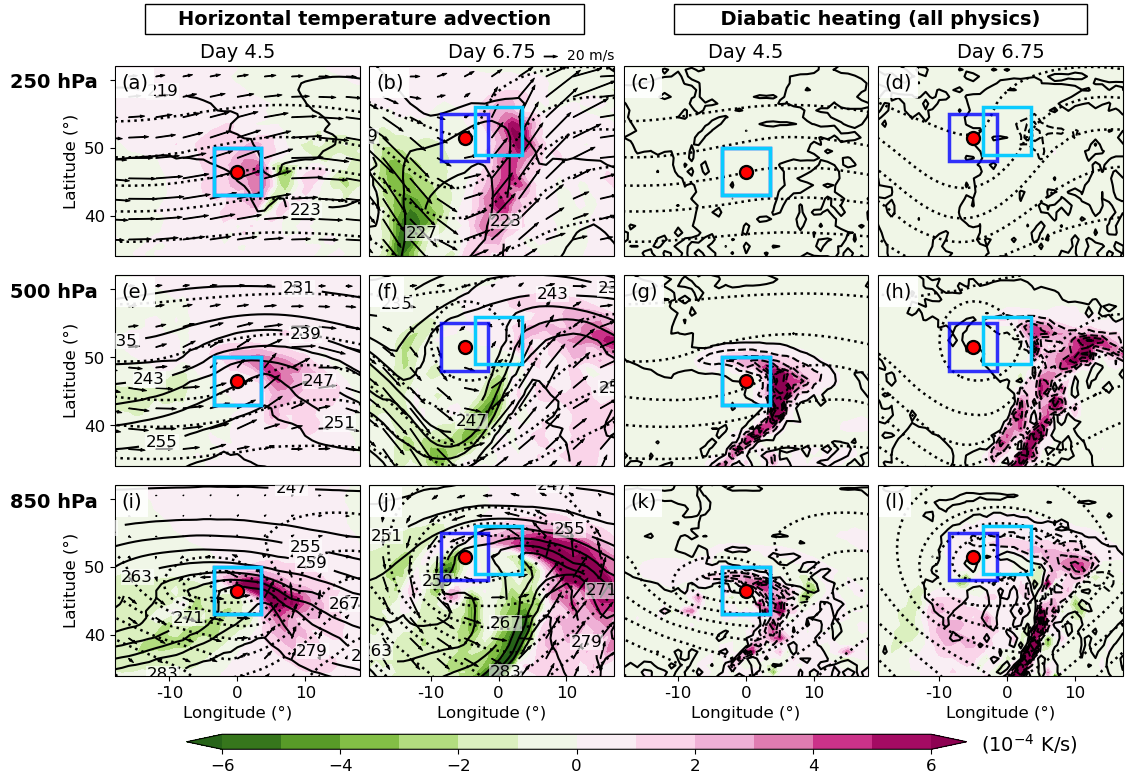

In [39]:
# Check the PTE results!

plt.rcParams['savefig.facecolor']='white'

lonmin=lons.min()+10
lonmax=lons.max()-4

latmin0=34
latmax0=61
latmin2=34
latmax2=63
latmin3=34
latmax3=63
# Showing Dp/dt term at a given time step
stp0 = 8   #4.5 day
stp2 = 11 #5.25 day
stp3 = 17 # stp=17: 6.75 day 
#stp3 = 16 # stp=16: 6.5 day  
#stp3 = 20 # stp=16: 7.5 day  
print('Simulation on day ',time[stp]+1)


lev1 = 9+10+5  #250 hPa
lev2 = 9+10+10+10+10 #500hPa
lev3 = 9+10+10+10+10+10+10+15 # 850 hPa
#lev = 9: 100hPa in our intepolated input data
ctv = 'k'
cmap = 'PiYG_r'
clevsomg=np.arange(-150,210,30)
# --------------------------------------------

print (level[lev1]/100,' (hPa)')
print (level[lev2]/100,' (hPa)')
print (level[lev3]/100,' (hPa)')

tfact = (6/dt) # This is for an easier comparison between the 6-h vs 1-h results (converting to the same unit)
clevs_mslp=np.arange(900,1060,10)
clevs=np.arange(-6e-4,7e-4,1e-4)
clevs_tv=np.arange(191,320,4)
if exp == "channel_80km_0003":
    shift_lon=24
    shift_lon2=12
    shift_lon3=-10
else:
    shift_lon=21
    #shift_lon=17
    shift_lon2=10
    #shift_lon3=0
    shift_lon3=-15 # for CTL
    #shift_lon3=-7 # for Tanom

for i in range(ntrack):
    #find timestep corresponding to track and data
    if track_dur[i] == time[stp0]  :
        cen_lon0=track_lon[i]+shift_lon
        cen_lat0=track_lat[i]
        print (cen_lon0-shift_lon,cen_lat0)
    if track_dur[i] == time[stp3]  :
        cen_lon3=track_lon[i]+shift_lon3
        cen_lat3=track_lat[i]
        print (cen_lon3-shift_lon3,cen_lat3)

TADV_avg_roll0=np.roll(tadv_data,shift_lon, axis=3)
mslp_roll0=np.roll(mslp,shift_lon,axis=2)
geopot_roll0=np.roll(geopot/9.8,shift_lon,axis=3)
u_roll0=np.roll(u,shift_lon,axis=3)
v_roll0=np.roll(v,shift_lon,axis=3)
Tv_roll0=np.roll(T_v,shift_lon,axis=3)
omega_roll0=np.roll(omega*100,shift_lon, axis=3)
dTdt_nwp_roll0=np.roll(dTdt_nwp_phy,shift_lon, axis=3)

TADV_avg_roll3=np.roll(tadv_data,shift_lon3, axis=3)
mslp_roll3=np.roll(mslp,shift_lon3,axis=2)
geopot_roll3=np.roll(geopot/9.8,shift_lon3,axis=3)
u_roll3=np.roll(u,shift_lon3,axis=3)
v_roll3=np.roll(v,shift_lon3,axis=3)
Tv_roll3=np.roll(T_v,shift_lon3,axis=3)
omega_roll3=np.roll(omega*100,shift_lon3, axis=3)
dTdt_nwp_roll3=np.roll(dTdt_nwp_phy,shift_lon3, axis=3)

fig = plt.figure(figsize=(13,7.5))
nrows = 3
ncols = 4

plotnum=1

for r in range(0,nrows):
    for c in range(0,ncols): 
        
        if r == 0: 
            lev = lev1
        elif r == 1: 
            lev = lev2
        elif r == 2: 
            lev = lev3
            
        if c == 0 or c == 2: 
            stp = stp0
            cen_lon = cen_lon0
            cen_lat = cen_lat0
            TADV_avg_roll = TADV_avg_roll0
            geopot_roll = geopot_roll0
            Tv_roll = Tv_roll0
            u_roll = u_roll0
            v_roll = v_roll0
            dTdt_nwp_roll = dTdt_nwp_roll0
            omega_roll = omega_roll0
            if exp == 'channel_'+res+'_0001':
                cen_lon80 = 19.5+shift_lon #CTL
                cen_lat80 = 46.5           #CTL
            elif exp == 'channel_'+res+'_0004':
                cen_lon80 = 18.5+shift_lon #Tanom
                cen_lat80 = 46.5           #Tanom
        elif c == 1 or c == 3:
            stp = stp3
            cen_lon = cen_lon3
            cen_lat = cen_lat3
            TADV_avg_roll = TADV_avg_roll3
            geopot_roll = geopot_roll3
            Tv_roll = Tv_roll3
            u_roll = u_roll3
            v_roll = v_roll3
            dTdt_nwp_roll = dTdt_nwp_roll3
            omega_roll = omega_roll3
            if exp == 'channel_'+res+'_0001':
                cen_lon80 = 56.5+shift_lon3 #CTL
                cen_lat80 = 52.5           #CTL
            elif exp == 'channel_'+res+'_0004':
                cen_lon80 = 55.5+shift_lon3 #Tanom
                cen_lat80 = 49.5           #Tanom
          
        
        print ('r,c=',r,c,'stp=',stp,'cen_lat=',cen_lat)
        if c <= 1: # Plot TADV 
                
            ax1 = plt.subplot(nrows,ncols,plotnum,projection=ccrs.PlateCarree())
            ax1.set_extent([lonmin, lonmax, latmin0, latmax0])    
            cd = plt.contourf(lons,lats,TADV_avg_roll[stp,lev,:,:]*1e4,clevs*1e4,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
            cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.8
                            ,transform=ccrs.PlateCarree())
            cst = plt.contour(lons,lats,Tv_roll[stp,lev,:,:],clevs_tv,colors=ctv,linewidths=1.5,transform=ccrs.PlateCarree())
            Q=plt.quiver(lons[::4],lats[::3],u_roll[stp,lev, ::3,::4],v_roll[stp,lev,::3,::4], scale=150,scale_units='inches', edgecolors='k',linewidths=0.7, transform=ccrs.PlateCarree())

            clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=12) 
            [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
                
        else: # Plot DIAB
            
            ax1 = plt.subplot(nrows,ncols,plotnum,projection=ccrs.PlateCarree())
            ax1.set_extent([lonmin, lonmax, latmin0, latmax0])    
            cd = plt.contourf(lons,lats,dTdt_nwp_roll[stp,lev,:,:]*1e4,clevs*1e4,cmap=cmap,extend='both',transform=ccrs.PlateCarree())
            cs = plt.contour(lons,lats,geopot_roll[stp,lev,:,:],linestyles='dotted',colors='k',linewidths=1.8
                            ,transform=ccrs.PlateCarree())
            cst = plt.contour(lons,lats,omega_roll[stp,lev,:,:],clevsomg,colors=ctv,linewidths=1.5,transform=ccrs.PlateCarree())

           # clabels = plt.clabel(cst, inline=True,fmt='%1.f', fontsize=12)
           # [txt.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.5)) for txt in clabels]
            
        for l in clabels:
            l.set_rotation(0)
        #gl = ax1.gridlines(linewidth=0)
        #if r == 2:
        #    gl.xlabels_bottom = True
        #else:
        #    gl.xlabels_bottom = False
        #if c == 0:
        #    gl.ylabels_left = True
        #else:
        #    gl.ylabels_left = False
        #gl.xformatter =LONGITUDE_FORMATTER
        #gl.yformatter =LATITUDE_FORMATTER
        #gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
        #gl.ylocator = mticker.FixedLocator(np.arange(10,90,10))
        #gl.xlabel_style = {'size': 12, 'color': 'k'}
        #gl.ylabel_style = {'size': 12, 'color': 'k'}
        
        if c==0:
            ax1.set_yticks([40,50,60])
            ax1.set_ylabel('Latitude (°)',fontsize=12)
            ax1.set_yticklabels(['40','50',''])
        if r==2:
            ax1.set_xticks([cen_lon80-10,cen_lon80,cen_lon80+10])
            ax1.set_xlabel('Longitude (°)',fontsize=12)
            ax1.set_xticklabels([-10,0,10])
        ax1.tick_params(axis='both', labelsize=12)

        #plt.scatter(cen_lon, cen_lat, c='k', s=80, zorder=25,transform=ccrs.PlateCarree())
        plt.scatter(cen_lon, cen_lat, c='k', s=100, zorder=20)
        plt.scatter(cen_lon, cen_lat, c='r', s=45, zorder=20)

        boxsize = 7 # horizontal size of column in deg used for PTE analysis

        ax1.add_patch(plt.Rectangle((cen_lon-boxsize/2,
                                 cen_lat-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 #ec='#1E62DE',
                                 ec='blue',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=0.8))
        #========================================
        if res == '2km':
            #plt.scatter(cen_lon80, cen_lat80, c='orange', s=80, zorder=25,transform=ccrs.PlateCarree())
            ax1.add_patch(plt.Rectangle((cen_lon80-boxsize/2,
                                 cen_lat80-boxsize/2),
                                 boxsize,
                                 boxsize,
                                 fc='none',
                                 ec='#0ACBFF',
                                 ls='solid',
                                 linewidth=2.5,
                                 zorder=20,
                                 alpha=1))
         #========================================
            
        if r == 0:
            
            xtxt = 0.5
            ytxt = 1.04

            ax1.text(xtxt, ytxt,
                 'Day '+str(stp*0.25+2.5),
                 ha='center',
                 #weight='bold',
                 fontsize=14,
                 #bbox=dict(ec='k',
                 #fc='white'),
                 transform=ax1.transAxes, zorder=50)
            
            if c == 0:
                plt.title('    Horizontal temperature advection    ',
                           bbox=dict(ec='k',
                           fc='white'), fontsize=14, fontweight='bold',x=1.02,y=1.17)
                #text = '(a)'
            elif c == 2:
                plt.title('      Diabatic heating (all physics)      ', 
                           bbox=dict(ec='k',
                           fc='white'), fontsize=14, fontweight='bold',x=1.05,y=1.17)
                #text = '(c)'
            #elif c == 1: 
                #text = '(b)'
            #elif c == 3: 
                #text = '(d)'
                
            #plt.text(0.02, 1.1, text, ha='center', va='top', transform=ax1.transAxes, fontsize=13) 

        if c == 0:
            plt.text(-0.43, 0.96, ''+str(int(level[lev]/100))+' hPa',
                    horizontalalignment='left',
                    verticalalignment='top',
                    #horizontalalignment='right',
                    #verticalalignment='center',
                    #rotation='vertical',
                    fontsize=14,
                    fontweight='bold',
                    transform=ax1.transAxes)
        if plotnum == 2:
            plt.quiverkey(Q,0.465,0.885, 20,'20 m/s',labelpos='E',coordinates='figure')

        if plotnum == 1:
            text = '(a)'
        elif plotnum == 2:
            text = '(b)'
        elif plotnum == 3:
            text = '(c)'
        elif plotnum == 4:
            text = '(d)'
        elif plotnum == 5:
            text = '(e)'  
        elif plotnum == 6:
            text = '(f)'
        elif plotnum == 7:
            text = '(g)'
        elif plotnum == 8:
            text = '(h)' 
        elif plotnum == 9:
            text = '(i)'
        elif plotnum == 10:
            text = '(j)'
        elif plotnum == 11:
            text = '(k)'
        elif plotnum == 12:
            text = '(l)'  
            
        plotnum = plotnum+1

        plt.text(0.027,0.96, text, ha='left', va='top', bbox=dict(ec='None',
                 fc='white',alpha=0.9),transform=ax1.transAxes, fontsize=14, zorder=60) 
##
##

fig.subplots_adjust(wspace = 0.04, hspace = 0.03)
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.18, -0.04, 0.6, 0.02]) # left,bottom,width,height
clb = plt.colorbar(cd,
                cax=cbar_ax,
                shrink=0.8,
                orientation='horizontal',
                extend='max')
        
        
#cb = fig.colorbar(cd, cax=cbar_ax, orientation='horizontal', extend='max')
tick_font_size = 12
clb.ax.tick_params(labelsize=tick_font_size)
clb.ax.set_title('('r'${10}^{-4}$'' K/s)', fontsize=14, x=1.07, y=-0.1, ha='left',
             transform=clb.ax.transAxes)
#fig1.suptitle('Tadv (shaded) & mslp (contours) on Day '+str(time[stp])+'\n'+exp+'',fontsize=14, weight='bold')
#plt.title('Day 6.5')
if exp == 'channel_80km_0001':
    plt.savefig('Fig7_Tadv_diab_'+exp+'_Day4p5&6p75.png', bbox_inches='tight',dpi=100)
else: 
    plt.savefig('Fig12_Tadv_diab_'+exp+'_Day4p5&6p75.png', bbox_inches='tight',dpi=100)
plt.show()